In [1]:
import numpy as np
from numpy import real
import glob
import math
import matplotlib.pyplot as plt

alpha=1.292              #electrostatic
beta=-3.26934291633      #covalent

## HUCKEL Molecular Orbital (HMO) Calculations

### CHEM344  Physical Chemistry
#### Department of Chemistry
#### Illinois Institute of Technology

#### Original Bash Code By Jingbai Li
#### Translated to Python by Joseph DePaolo-Boisvert
#### HUCKELMO Version 2.0  Aug 30th 2017
#### Nov 1st, 2022

In [2]:
from IPython.testing import test
from google.colab import drive
drive.mount('/content/drive')
structures_dir = '/content/drive/MyDrive/Huckel/structures/'

Mounted at /content/drive


In [13]:
def get_matrix(mol2_fn):
    mol2_name = mol2_fn.split('/')[-1]
    # #Initial Parameters
    ele_num=0                #electrons
    orb=0                    #orbitals
    # alpha beta types: 1:C=C-C 2:C-N-C 3:C=N-C
    # diagonal-alpha, alpha’=alpha + h * beta, C=C:0 C=N:2 C-N:1.5
    # connected-beta, beta’=k*beta, C=C:1 C=N:1 C-N:0.8
    with open(mol2_fn, 'r') as f:
        lines = [line[:-1] if line.endswith('\n') else line for line in f.readlines()]
    
    atomsec = lines[lines.index("@<TRIPOS>ATOM") + 1:lines.index("@<TRIPOS>BOND")]
    atomsec = [[element for element in atom.split(' ') if element != ''] for atom in atomsec]
    num_atoms = len(lines)
    
    bondsec = lines[lines.index("@<TRIPOS>BOND") + 1 :]
    if bondsec[-1] == '':
        bondsec.pop(-1)
    
    bonds = []
    for bond in bondsec:
        bond = bond.split(' ')
        if bond[-1] == '1':
            bond[-1] = 'S'
        elif bond[-1] == '2':
            bond[-1] = 'D'
        else:
            bond[-1] = 'N'
        bonds.append(bond)
    bondsec = bonds
    numbonds = len(bondsec)
    #print(atomsec)
    #print(bondsec)
    
    # #detect atom type, matrix dimension, diagonal element
    typ = {}
    dim = len(atomsec)
    matrix = np.zeros((dim, dim))
    for atom in atomsec:
        atom_type = atom[-1]
        atom_ind = int(atom[0]) - 1
        if atom_type == 'C':
            valence = 0 #the number of times it is listed in a bond
            for bond in bondsec:
                if atom[0] in bond[1:3]:
                    valence += 1
            if valence < 4:
                typ[atom[0]] = 1
                h = 0.000
                ele_num += 1
                orb += 1
            else:
                typ[atom[0]] = 0
            
        elif atom_type == 'N':
            pyridine = False
            for bond in bondsec:
                if atom[0] in bond and 'D' in bond:
                    pyridine = True
            if pyridine:
                typ[atom[0]] = 3
                h = 2.000
                ele_num += 1
                orb += 1
            else:
                typ[atom[0]] = 2
                h = 1.500
                ele_num += 2 ####
                orb += 1
        
        else:
            typ[atom[0]] = 0
            h = -1 * alpha / beta
        
        matrix[atom_ind, atom_ind] = alpha + h * beta
    #print(typ)
    #print(matrix)
    
    # #detect bond type, none-zero matrix element
    for bond in bonds:
        b1 = bond[1]
        b2 = bond[2]
        if typ[b1] == 0 or typ[b2] == 0:
            k = 0.000
        elif typ[b1] == 2 or typ[b2] == 2:
            k = 0.800
        else:
            k = 1.000
        b1_ind, b2_ind = int(b1) - 1, int(b2) - 1
        matrix[b1_ind, b2_ind] = k * beta
        matrix[b2_ind, b1_ind] = k * beta
    
    return mol2_name, matrix, ele_num, orb


def analyze_matrix(mol2_name, matrix, ele_num, orbs):
    print('####################################################################')
    print(f'####  Begin Analyze {mol2_name}  ####')
    b = np.linalg.eigvals(matrix)
    energies = [element for element in np.sort(real(b)) if element != 0 and element != alpha]
    
    print(f'Num_Electrons = {ele_num}')
    
    base = ele_num // 2
    
    print()
    print('Orbital Energies (au)')
    
    for i in range(len(energies)):
        s = f'{i+1}      {energies[i]:.4f}'
        if i+1  == base: # base is 1 indexed and i is zero
            s = f'{i+1} HOMO {energies[i]:.4f}'
            homo_ind = i
        elif i+1 == base + 1:
            s = f'{i+1} LUMO {energies[i]:.4f}'
            lumo_ind = i
        print(s)
    
    gap_energy = energies[lumo_ind] - energies[homo_ind]
    print()
    print(f'HOMO-LUMO Gap = {gap_energy:.5f} (au)')
    print()
    x = np.arange(100,1601)
    y = lambda x, gap_energy : math.sqrt(2/math.pi)/70*math.e**(-2*((x-(2.998*10**8)*10**9/((1.60217656*10**(-19))/(6.626*10**(-34)))/(gap_energy))/70)**2)
    
    plt.clf()
    plt.title(mol2_name)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
    _ = plt.plot(x, y(x, gap_energy))
    plt.show()
    return x, y

In [14]:
mol2s = glob.glob(f'{structures_dir}*.mol2')
matrices = [get_matrix(mol2) for mol2 in mol2s]

####################################################################
####  Begin Analyze 11DIETHYL44DICARBOCYANINE.mol2  ####
Num_Electrons = 27

Orbital Energies (au)
1      -6.8647
2      -6.8505
3      -5.1003
4      -4.8167
5      -4.6027
6      -4.3707
7      -3.4711
8      -1.9773
9      -1.9773
10      -1.9773
11      -1.5638
12      -1.2143
13 HOMO 0.4379
14 LUMO 1.9684
15      3.1863
16      4.5613
17      4.5613
18      4.5613
19      4.8706
20      5.0290
21      6.2435
22      6.9547
23      7.3823
24      8.7320
25      8.7900

HOMO-LUMO Gap = 1.53054 (au)



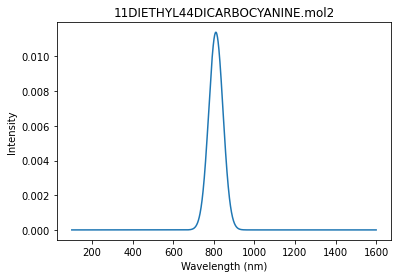

####################################################################
####  Begin Analyze benzene.mol2  ####
Num_Electrons = 6

Orbital Energies (au)
1      -5.2467
2      -1.9773
3 HOMO -1.9773
4 LUMO 4.5613
5      4.5613
6      7.8307

HOMO-LUMO Gap = 6.53869 (au)



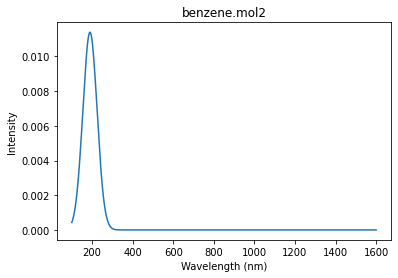

####################################################################
####  Begin Analyze 11DIETHYL44CARBOCYANINE.mol2  ####
Num_Electrons = 25

Orbital Energies (au)
1      -6.8853
2      -6.8290
3      -5.0627
4      -4.7473
5      -4.5551
6      -4.1499
7      -2.5504
8      -1.9773
9      -1.9773
10      -1.6171
11      -1.3920
12 HOMO 0.2545
13 LUMO 2.0635
14      3.4715
15      4.5613
16      4.5613
17      4.7907
18      4.8978
19      5.5169
20      6.7738
21      7.2519
22      8.6696
23      8.8385

HOMO-LUMO Gap = 1.80901 (au)



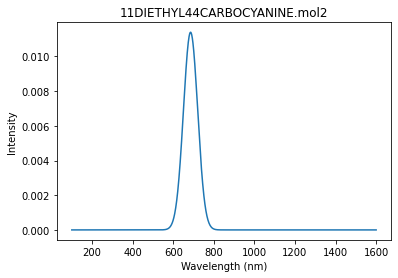

####################################################################
####  Begin Analyze 11DIETHYL22DICARBOCYANINE.mol2  ####
Num_Electrons = 27

Orbital Energies (au)
1      -6.9156
2      -6.8971
3      -5.1272
4      -4.9388
5      -4.2954
6      -3.7121
7      -3.5421
8      -2.9327
9      -2.2227
10      -1.4838
11      -1.4825
12      -1.2672
13 HOMO 0.4081
14 LUMO 1.9826
15      2.9431
16      3.8753
17      4.7218
18      4.7797
19      4.9876
20      5.6117
21      6.2801
22      7.0560
23      7.5904
24      8.5263
25      8.5464

HOMO-LUMO Gap = 1.57451 (au)



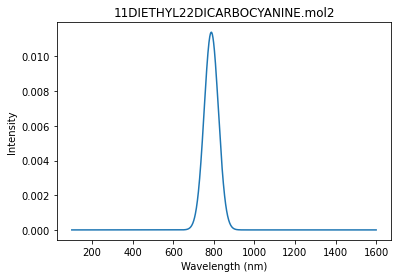

####################################################################
####  Begin Analyze 11DIETHYL22CYANINE.mol2  ####
Num_Electrons = 23

Orbital Energies (au)
1      -7.0482
2      -6.7423
3      -5.0855
4      -4.6833
5      -3.7391
6      -3.5565
7      -2.8255
8      -1.9773
9      -1.4828
10      -1.4821
11 HOMO -0.0782
12 LUMO 2.1863
13      3.2767
14      4.5613
15      4.7707
16      4.8491
17      5.5573
18      6.3915
19      7.3651
20      8.4693
21      8.5975

HOMO-LUMO Gap = 2.26446 (au)



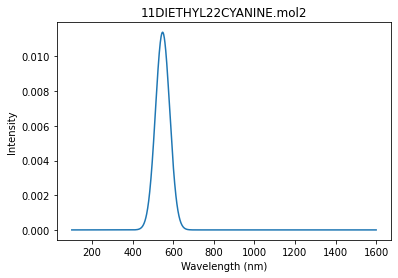

####################################################################
####  Begin Analyze benzene-test.mol2  ####
Num_Electrons = 6

Orbital Energies (au)
1      -5.2467
2      -1.9773
3 HOMO -1.9773
4 LUMO 4.5613
5      4.5613
6      7.8307

HOMO-LUMO Gap = 6.53869 (au)



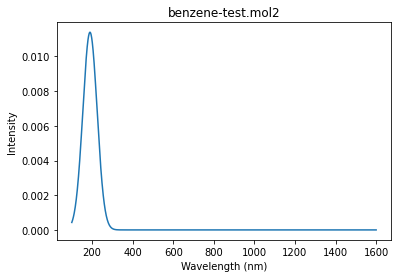

####################################################################
####  Begin Analyze 11DIETHYL22CYANINE-new.mol2  ####
Num_Electrons = 22

Orbital Energies (au)
1      -8.3972
2      -6.8779
3      -5.1876
4      -4.8632
5      -3.8591
6      -3.5760
7      -2.8360
8      -1.9773
9      -1.5097
10      -1.4824
11 HOMO -0.0650
12 LUMO 2.2573
13      3.2956
14      4.5613
15      4.7880
16      4.9121
17      5.5658
18      6.4029
19      7.3830
20      8.4927
21      8.6619

HOMO-LUMO Gap = 2.32232 (au)



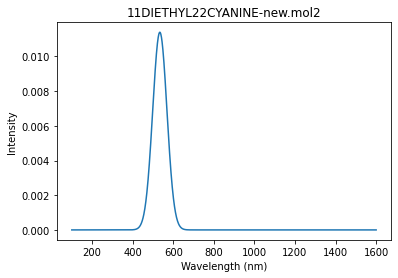

####################################################################
####  Begin Analyze 11DIETHYL22DICARBOCYANINE-new.mol2  ####
Num_Electrons = 26

Orbital Energies (au)
1      -8.3895
2      -6.9064
3      -5.2030
4      -5.0316
5      -4.4482
6      -3.8004
7      -3.5577
8      -2.9407
9      -2.2239
10      -1.5113
11      -1.4831
12      -1.2685
13 HOMO 0.4267
14 LUMO 2.0377
15      2.9761
16      3.8757
17      4.7293
18      4.8124
19      5.0294
20      5.6171
21      6.2857
22      7.0746
23      7.5962
24      8.5350
25      8.6257

HOMO-LUMO Gap = 1.61105 (au)



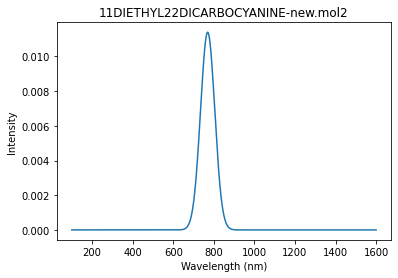

####################################################################
####  Begin Analyze 11DIETHYL44CARBOCYANINE-new.mol2  ####
Num_Electrons = 24

Orbital Energies (au)
1      -8.2642
2      -6.8580
3      -5.4321
4      -4.8758
5      -4.5747
6      -4.1586
7      -2.5580
8      -1.9773
9      -1.9773
10      -1.6259
11      -1.4061
12 HOMO 0.2769
13 LUMO 2.1234
14      3.5132
15      4.5613
16      4.5613
17      4.8075
18      4.9719
19      5.5702
20      6.7751
21      7.2544
22      8.6965
23      8.8698

HOMO-LUMO Gap = 1.84649 (au)



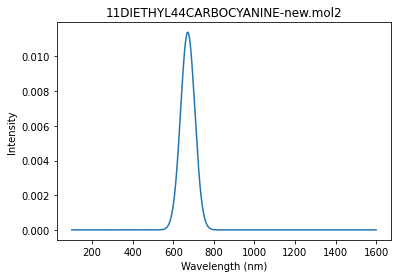

####################################################################
####  Begin Analyze 11DIETHYL44DICARBOCYANINE-new.mol2  ####
Num_Electrons = 25

Orbital Energies (au)
1      -8.2648
2      -8.2636
3      -5.5051
4      -5.3408
5      -4.7093
6      -4.3707
7      -3.5056
8      -1.9773
9      -1.9773
10      -1.9773
11      -1.5841
12 HOMO -1.2386
13 LUMO 0.4825
14      2.0730
15      3.2722
16      4.5613
17      4.5613
18      4.5613
19      4.9856
20      5.1913
21      6.2679
22      6.9547
23      7.3892
24      8.7920
25      8.8448

HOMO-LUMO Gap = 1.72105 (au)



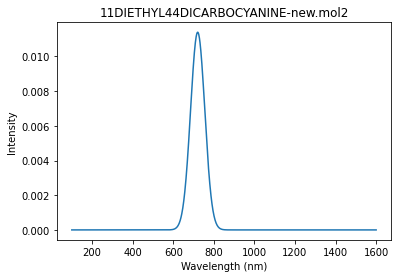

In [16]:
for matrix_set in matrices:
  analyze_matrix(*matrix_set)